# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner 


<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment, follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" on the other hand is descriptive).

<hr style="height:2pt">

In [2]:
import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm

%matplotlib inline

print(f"Using TensorFlow version: {tf.__version__}")
print(f"Using TensorFlow Datasets version: {tfds.__version__}")
print(f"Using TensorFlow AddOns version: {tfa.__version__}")

Using TensorFlow version: 2.4.1
Using TensorFlow Datasets version: 4.2.0
Using TensorFlow AddOns version: 0.12.1


**Please run these cells below.** First we set our local working directory to ensure our provided code in PART 2 works correctly, and then we enable [TensorFlow eager execution](https://www.tensorflow.org/guide/eager) and print a summary of whether there are local GPUs available for training your models. As long as you are using the provided `cs109b.yml` conda environment, you should expect to see a TensorFlow version >=2.3.0, which should allow this notebook to run without error.

In [3]:
# RUN THIS CELL

working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)

In [4]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print(f"\nNumber of replicas: {strategy.num_replicas_in_sync}\n")

devices = tf.config.experimental.get_visible_devices()
print(f"Devices: {devices}\n")
print(f"{tf.config.experimental.list_logical_devices('GPU')}\n")

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}\n")
print(f"All Pysical Devices: {tf.config.list_physical_devices()}")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Number of replicas: 1

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

[]

GPU Available: []

All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<a id="contents"></a>

## Notebook Contents

- [**PART 1 [55 pts]: Building a Basic CNN Model**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [45 pts]: Regression with CNN**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem, and use saliency maps to understand where the network is placing its "attention."


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the GPU-enabled JupyterHub environment provided to you as part of this course** (or you could also take a look at Google Colab's runtime settings for accessing a GPU-enabled environment free of cost).
- **Models that take hours to train on CPUs can be trained in just minutes when using GPUs.**
- Additionally, **if you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your trained model weights for later use** (as is required in [PART 2, question 2.2.3](#q223)).


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [55 pts]: Building a Basic CNN Model

[Return to contents](#contents)


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="part1questions"></a>

### <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**[1.1:](#s11) Loading CIFAR-10 and Constructing the Model**

<a id="q111"></a>

- **[1.1.1:](#s111)** Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.

<a id="q112"></a>

- **[1.1.2:](#s112)** Construct a model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order, and you can use as many layers as you'd like) to build your classification model.

  - You may use an existing architecture like AlexNet or VGG16, or create one of your own design.

  - However, you MUST construct the network yourself and not use a pre-written implementation.

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.


<a id="q12"></a>

**[1.2:](#s12) Model parameter growth**

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. **HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.

<a id="q13"></a>

**[1.3:](#s13) Choose a model, train and evaluate it**

<a id="q131"></a>

- **[1.3.1:](#s131)** Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Your validation and test accuracies should both exceed 70%.

<a id="q132"></a> 

- **[1.3.2:](#s132)** Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.
 

<a id="q14"></a> 

**[1.4:](#s14) Techniques to visualize the model**
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use activation maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_activation_maps` to aid in extracting activation maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), including a more recent development, a [Grad-CAM](https://arxiv.org/abs/1610.02391) saliency heatmap, which has been shown to better indicate the attention of CNNs.
 
<a id="q141"></a> 

- **[1.4.1:](#s141)** For a given input image from the test set that is correctly classified, use your model and extract 9 activation maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the activation maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_activation_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

<a id="q142"></a> 

- **[1.4.2:](#s142)** For the same input image generate and plot a SmoothGrad saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM saliency heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); however, please stick to "perceptionally uniform sequential" or "sequential" colormaps because they are far easier to interpret. Arrange the three plots in a row using subplots: Original Image, SmoothGrad saliency Map, Grad-CAM saliency heatmap. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

<a id="q143"></a> 

- **[1.4.3:](#s143)** Repeat 1.4.2, but for an image from the test set that is **incorrectly classified**, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the **incorrect** class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)

<a id="s11"></a>
<a id="s111"></a>
<div class='exercise-r'>  

**[1.1:](#q11) Loading CIFAR-10 and Constructing the Model**

- **[1.1.1:](#q111)** Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.

</div>

In [38]:
# your code here
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

For now, we don't batch out training data (necessary for an efficient implementation of SGD). We'll do that later when training the model (this will also allow us to gather all of the hyperparameters definition in the same 'region').

In terms of preprocessing regarding images, there are several steps to be taken:
- Normalizing the images
- Resizing the images
- Data Augmentation (not done for now)
- Create a Validation Set (not specific to images, but useful for monitoring training)

In [46]:
x_train = x_train/255
x_test = x_test/255

#x_train, x_val = x_train[0:40000],x_train[40000:50000]
#y_train, y_val = y_train[0:40000],y_train[40000:50000]

print('Here are the shapes of the samples and labels ')
print('------------------------------')
print(x_train.shape, 'train samples')
print(y_train.shape, 'train labels\n')
print(x_test.shape, 'test samples')
print(y_test.shape, 'test labels\n')
print(x_val.shape, 'validation samples')
print(y_val.shape, 'validation labels\n')



Here are the shapes of the samples and labels 
------------------------------
(40000, 32, 32, 3) train samples
(40000, 1) train labels

(10000, 32, 32, 3) test samples
(10000, 1) test labels

(10000, 32, 32, 3) validation samples
(10000, 1) validation labels



<a id="s112"></a>
<div class='exercise-r'>  

**[1.1.2:](#q112)** Construct a model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order, and you can use as many layers as you'd like) to build your classification model.

  - You may use an existing architecture like AlexNet or VGG16, or create one of your own design.

  - However, you MUST construct the network yourself and not use a pre-written implementation.

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.

</div>

Let's implement the **AlexNet** architecture. 

We are going to use a batch size of 64.

In [47]:
# your code here
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 3), batch_size=64))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [48]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (64, 28, 28, 32)          896       
_________________________________________________________________
conv2d_100 (Conv2D)          (64, 28, 28, 32)          9248      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (64, 14, 14, 32)          0         
_________________________________________________________________
dropout_39 (Dropout)         (64, 14, 14, 32)          0         
_________________________________________________________________
conv2d_101 (Conv2D)          (64, 14, 14, 64)          18496     
_________________________________________________________________
conv2d_102 (Conv2D)          (64, 14, 14, 64)          36928     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (64, 7, 7, 64)          

<a id="s12"></a>
<div class='exercise-r'>  

**[1.2:](#q12) Model parameter growth**

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. **HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.

</div>

In [49]:
# your code here
def define_architecture(num_filters):
    """Here, for the sake of realistic implementation, num_filters should be a power of 2. Our model will implement a 
    Cascade of Conv2D layers, with a dohbling number of filters, and a MaxPooling layer after every Convolutional
    layer"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 3), batch_size=64))
    model.add(tf.keras.layers.Conv2D(filters = num_filters, kernel_size=(2, 2), activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters = 2*num_filters, kernel_size=(2, 2), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters = 4*num_filters, kernel_size=(2, 2), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

def count_params(model):
    return model.count_params()

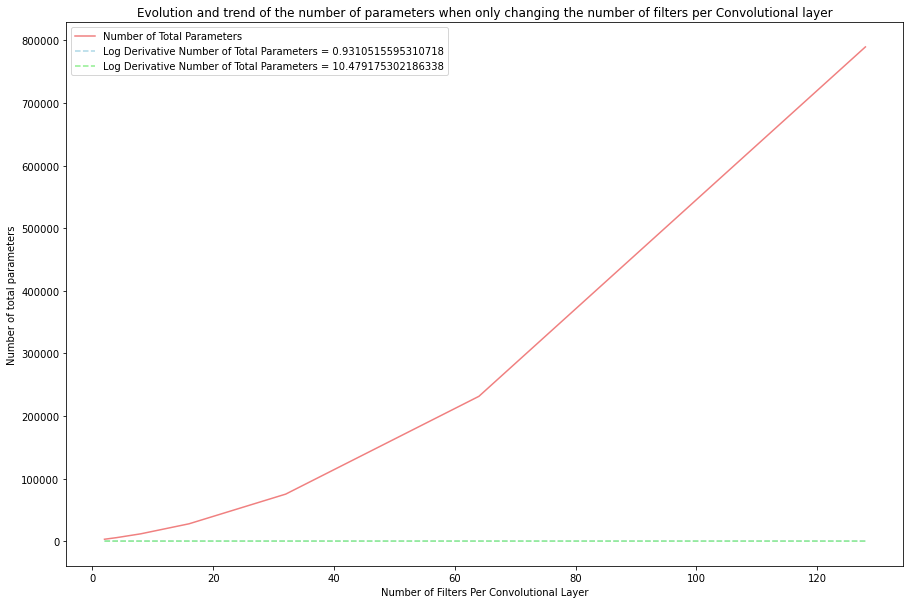

In [50]:
num_filters = [2, 4, 8, 16, 32, 64, 128]
count_parameters = [count_params(define_architecture(num_filter)) for num_filter in num_filters]
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(num_filters, count_parameters, color='lightcoral', label='Number of Total Parameters')
ax.plot(num_filters, np.log(count_parameters), color='lightblue', linestyle='--', label='Log Derivative Number of Total Parameters = ' +str(np.mean(np.log(count_parameters[1:]) - np.log(count_parameters[:-1]))))
ax.plot(num_filters, np.log(count_parameters), color='lightgreen', linestyle='--', label='Log Derivative Number of Total Parameters = ' +str(np.mean(np.log(count_parameters))))
ax.set_xlabel('Number of Filters Per Convolutional Layer')
ax.set_ylabel('Number of total parameters')
ax.set_title('Evolution and trend of the number of parameters when only changing the number of filters per Convolutional layer')
plt.legend()
plt.show(fig)

**INTERPRETATION:**

- *What have we done ?*: The first step of this analysis was to devise an architecture and stick to it. In our case, this architecture has been defined in 1.1.2. The particularity of this architecture is that the number of filters doubles every Convolutional layer. Therefore, when varying the number of filters, I wanted to keep this doubling structure. 
- *What is the result ?*: We can see from the plot that the dependency seems to be explonential. The relationship deduced is $log(params_{n+1}) - log(params_n) = a$, with $a \approx 0.93$. Therefore, we have $params_{n+1} = e^aparams_n$ and $params_n = e^{a(n-1)}params_2$: the dependency of the total number of parameters in the number of filters is **exponential**.
- *Why is that so?*: when writing the formula for the total number of filters, we can see that the number of filters $n$ for the layer $i$ becomes the number of dimension of layer $i+1$, when the number of filters becomes $2*n$, which adds up something proportional to $2n^2$ in the toal number of parameters (depending on the kernel side). 

**Conclusion**: We could be misled thinking that the relationship in the number of filters is exponential. However, a little calculation will show us that the relationship is quadratic (with a very important coefficient).



<a id="s13"></a>
<a id="s131"></a>
<div class='exercise-r'>  

**[1.3:](#q13) Choosing a model, training, and evaluating it**

- **[1.3.1:](#q131)** Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Your validation and test accuracies should both exceed 70%.

</div>

#### Retained model

I decided to stick with my original architecture, and will see how this architecture performs. 

In [51]:
# your code here
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3), batch_size=64))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (64, 32, 32, 32)          896       
_________________________________________________________________
conv2d_127 (Conv2D)          (64, 32, 32, 32)          9248      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (64, 16, 16, 32)          0         
_________________________________________________________________
dropout_49 (Dropout)         (64, 16, 16, 32)          0         
_________________________________________________________________
conv2d_128 (Conv2D)          (64, 16, 16, 64)          18496     
_________________________________________________________________
conv2d_129 (Conv2D)          (64, 16, 16, 64)          36928     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (64, 8, 8, 64)          

The total number of parameters is 550570, which seems a bit low. Since the CIFAR-10 dataset is recognized as an 'easy' dataset to learn from, this might be sufficient to use it. Let's see how it performs.

#### Training and Monitoring the training

In [52]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = SGD(lr=0.001, momentum=0.9) , metrics=['accuracy'])

history = model.fit(x=x_train, 
                    y=y_train,
          epochs=15,batch_size=64,
          validation_split=0.2,
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/15
500/500 [==============================] - 243s 483ms/step - loss: 2.3025 - accuracy: 0.1028 - val_loss: 2.3018 - val_accuracy: 0.1025
Epoch 2/15
500/500 [==============================] - 297s 595ms/step - loss: 2.3017 - accuracy: 0.1033 - val_loss: 2.3003 - val_accuracy: 0.1110
Epoch 3/15
500/500 [==============================] - 205s 410ms/step - loss: 2.3005 - accuracy: 0.1128 - val_loss: 2.2967 - val_accuracy: 0.1493
Epoch 4/15
500/500 [==============================] - 195s 390ms/step - loss: 2.2969 - accuracy: 0.1222 - val_loss: 2.2908 - val_accuracy: 0.1490
Epoch 5/15
500/500 [==============================] - 202s 405ms/step - loss: 2.2942 - accuracy: 0.1266 - val_loss: 2.2799 - val_accuracy: 0.2046
Epoch 6/15
500/500 [==============================] - 197s 395ms/step - loss: 2.2843 - accuracy: 0.1413 - val_loss: 2.2971 - val_accuracy: 0.1133
Epoch 7/15
500/500 [==============================] - 198s 396ms/step - loss: 2.2927 - accuracy: 0.1207 - val_loss: 2.2823 -

<a id="s132"></a>
<div class='exercise-r'>  

**[1.3.2:](#q132)** Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

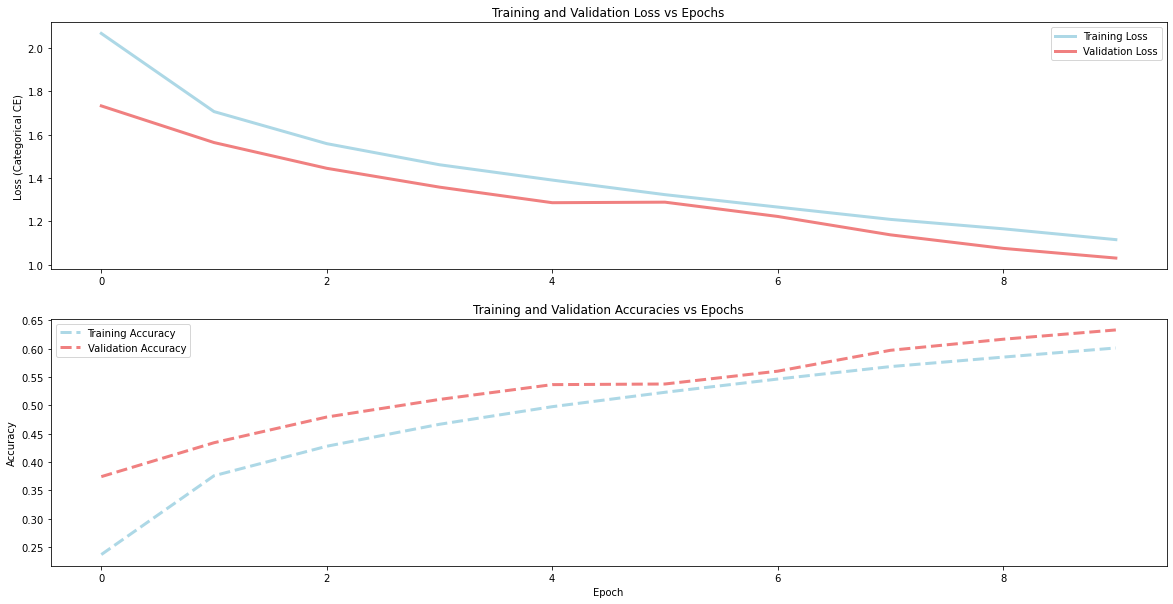

In [13]:
fig, ax = plt.subplots(2, figsize=(20, 10))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax[0].plot(train_loss, linewidth=3, label = 'Training Loss', color = 'lightblue')
ax[1].plot(train_accuracy, linewidth=3, label = 'Training Accuracy', color = 'lightblue', linestyle='--')
ax[0].plot(val_loss, linewidth=3, label = 'Validation Loss', color = 'lightcoral')
ax[1].plot(val_accuracy, linewidth=3, label = 'Validation Accuracy', color = 'lightcoral', linestyle='--')


ax[0].set_title('Training and Validation Loss vs Epochs')
ax[1].set_title('Training and Validation Accuracies vs Epochs')
plt.xlabel('Epoch')
ax[0].set_ylabel('Loss (Categorical CE)')
ax[1].set_ylabel('Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [14]:
print('The test accuracy is ', np.mean(np.argmax(model(x_test), axis=1)==y_test.reshape(-1,)))

The test accuracy is  0.6329


<a id="s14"></a>
<a id="s141"></a>
<div class='exercise-r'>  

**[1.4:](#q14) Techniques to visualize the model**
    
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use activation maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_activation_maps` to aid in extracting activation maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), including a more recent development, a [Grad-CAM](https://arxiv.org/abs/1610.02391) saliency heatmap, which has been shown to better indicate the attention of CNNs.

- **[1.4.1:](#q141)** For a given input image from the test set that is correctly classified, use your model and extract 9 activation maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the activation maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_activation_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

</div>

In [15]:
def get_activation_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing
    an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): activation map stacked output by the
        specified layer
    """
    model_ = Model(
        inputs=[model.input], outputs=[model.layers[layer_id].output]
    )
    return model_.predict(
        np.expand_dims(input_image, axis=0)
    )[0,:,:,:].transpose((2,0,1))


# A dictionary to turn class index into class labels for CIFAR-10

cifar10dict = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

In [16]:
import warnings

warnings.filterwarnings('ignore')

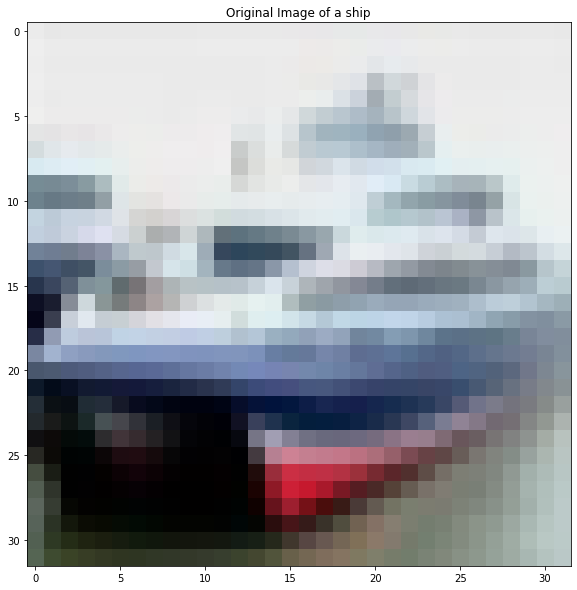

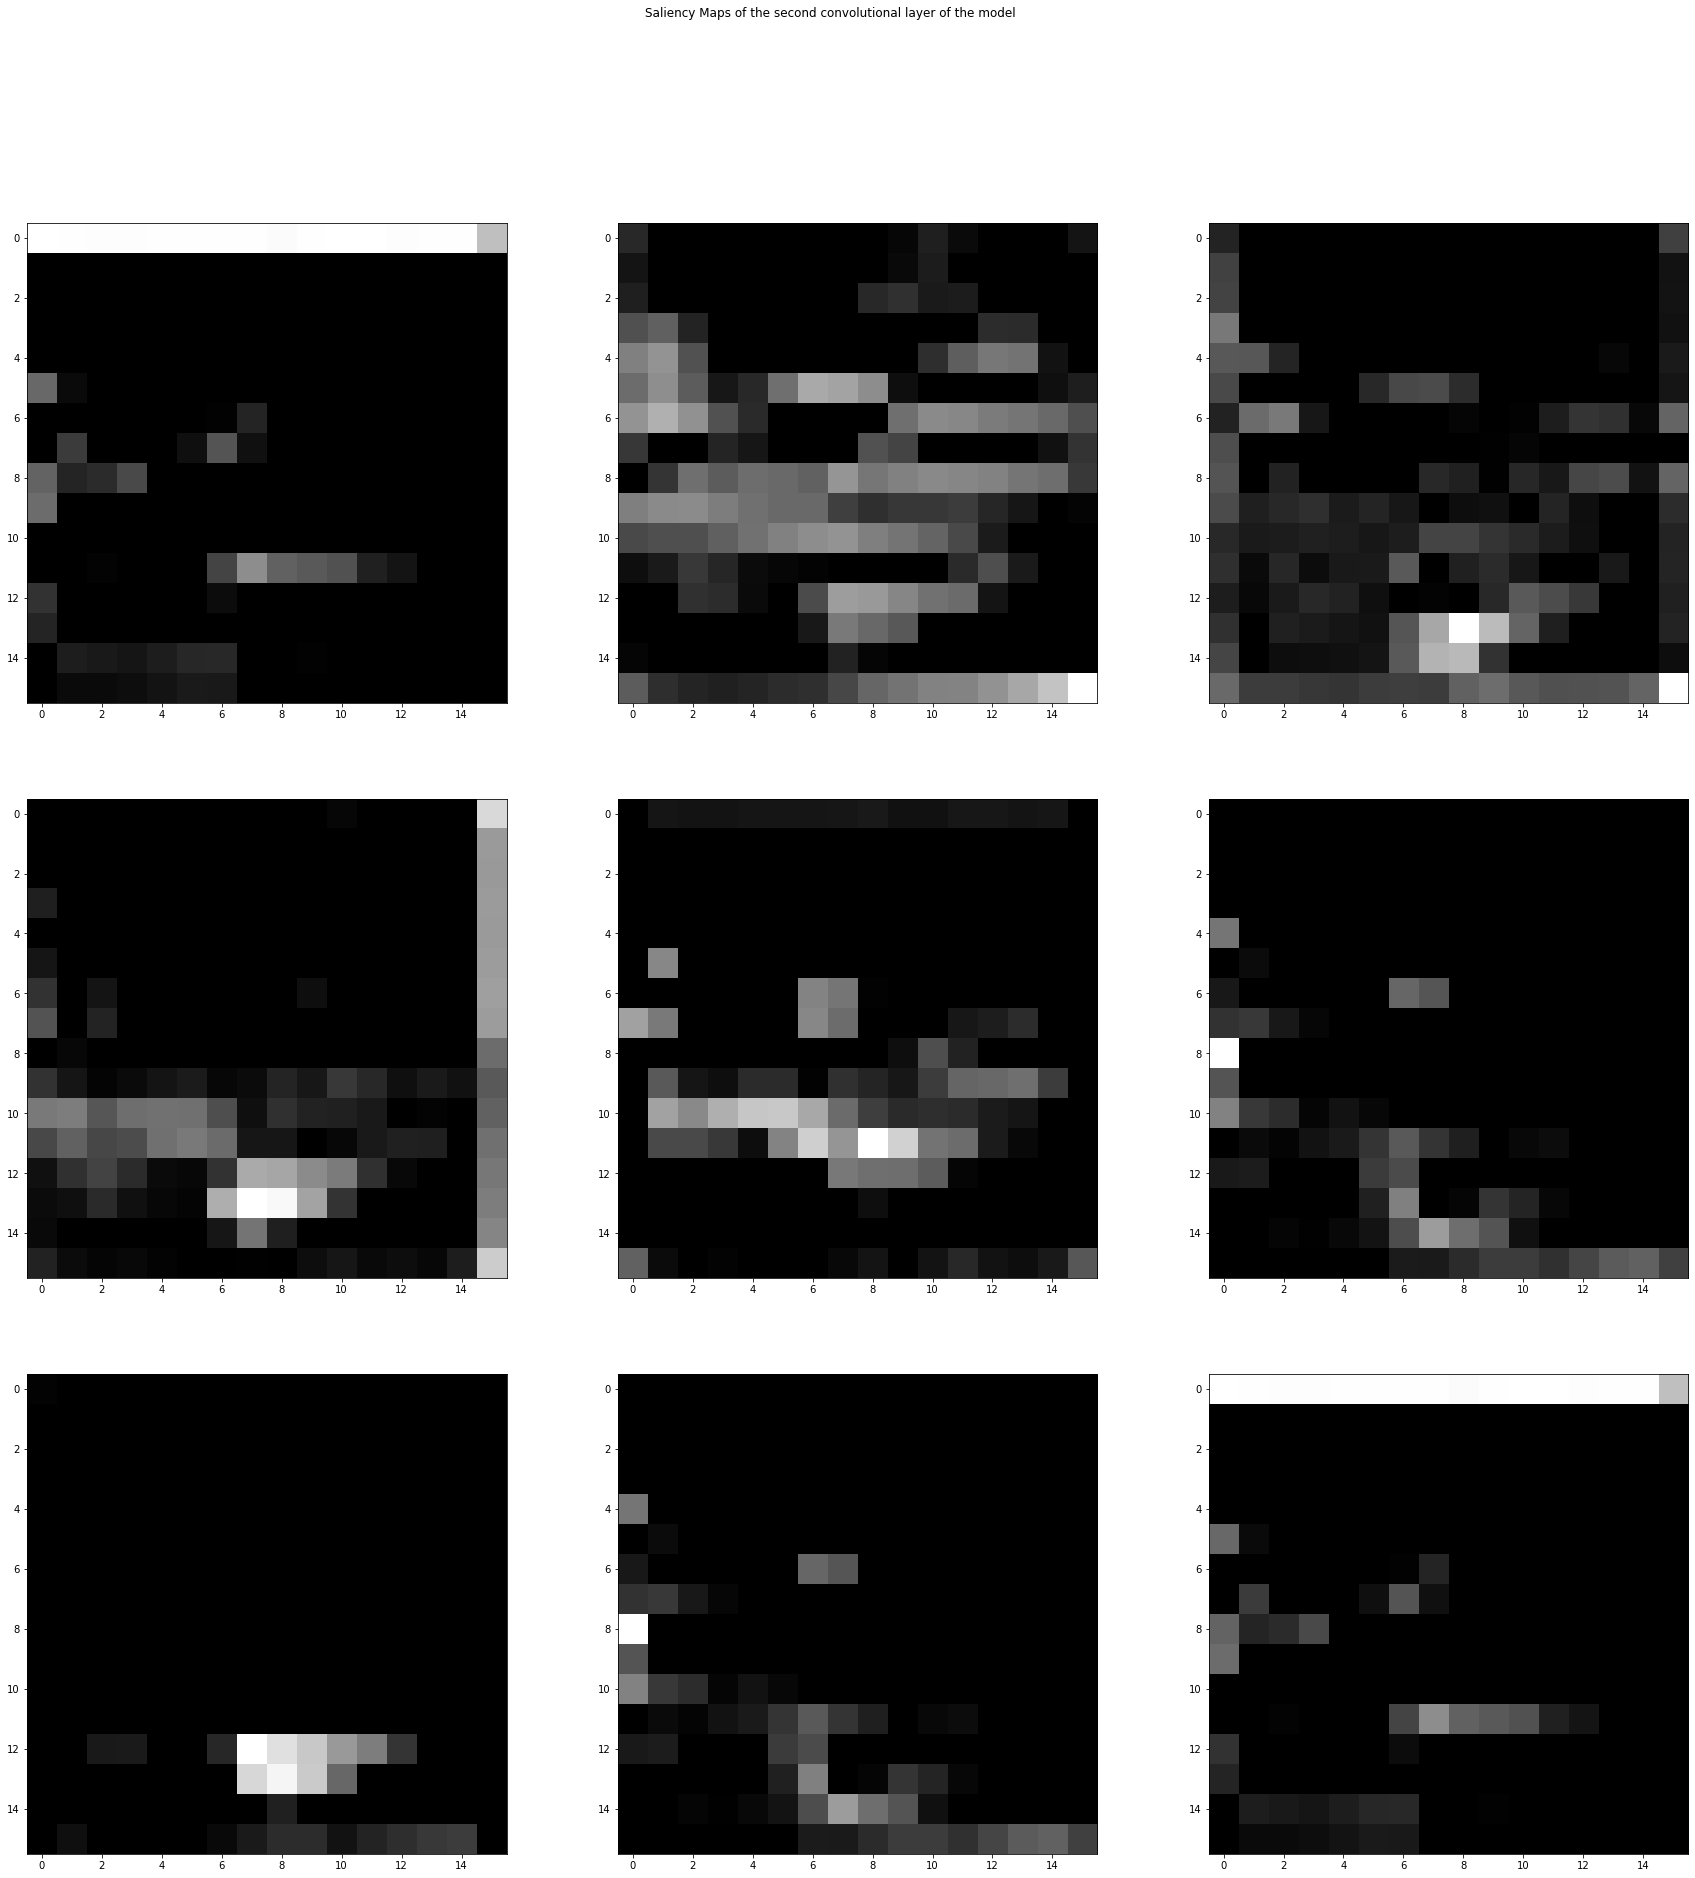

In [17]:
# your code here
s = np.random.randint(0,10000)
#We make sure that the image is correctly labeled
while y_test[s]!=y_pred[s]:
    s=np.random.randint(0,10000)
    
sample, label = x_test[s], y_test[s]
output = get_activation_maps(model, 3, sample)
samples = output[np.random.randint(0, 32, size=9)]
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(sample)
ax.set_title('Original Image of a ' + str(cifar10dict.get(label[0])))
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
plt.suptitle('Saliency Maps of the second convolutional layer of the model')
for i, ax in enumerate(ax.ravel()):
    ax.imshow(samples[i], cmap='gray')

<a id="s142"></a>
<div class='exercise-r'>  

**[1.4.2:](#q142)** For the same input image generate and plot a SmoothGrad saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM saliency heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); however, please stick to "perceptionally uniform sequential" or "sequential" colormaps because they are far easier to interpret. Arrange the three plots in a row using subplots: Original Image, SmoothGrad saliency Map, Grad-CAM saliency heatmap. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

</div>

In [18]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(output):
    return output[0]

expanded = np.expand_dims(sample, axis=0)

In [19]:
# your code here
saliency = Saliency(model, model_modifier=model_modifier, clone=False)
saliency_map = saliency(loss, expanded, smooth_samples=20, smooth_noise=0.20) 
saliency_map = normalize(saliency_map)

In [20]:
gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)
cam = gradcam(loss, expanded, penultimate_layer=-1)
cam = normalize(cam)

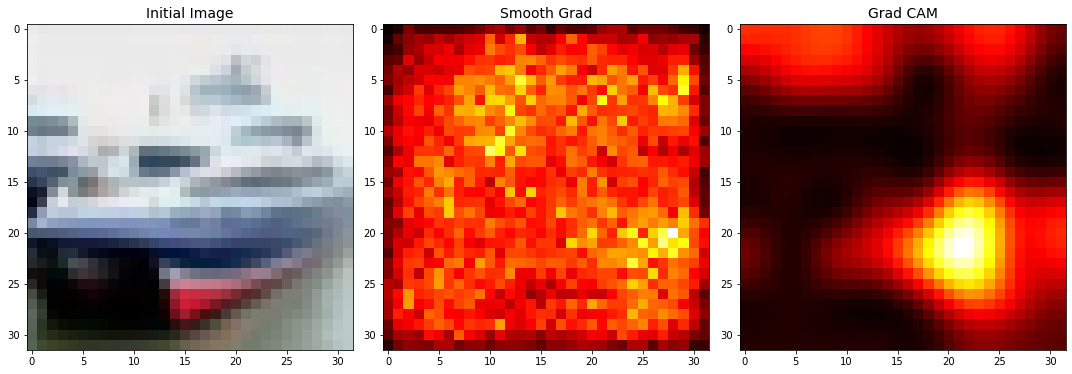

In [21]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].set_title('Initial Image', fontsize=14)
ax[0].imshow(sample, cmap='hot')
ax[1].set_title('Smooth Grad', fontsize=14)
ax[1].imshow(saliency_map[0], cmap='hot')
ax[2].set_title('Grad CAM', fontsize=14)
ax[2].imshow(cam[0], cmap='hot')
plt.tight_layout()
plt.show()

**INTERPRETATION:**

From the three different saliency maps, we can see that, from my point of view, the easier image to interpret is the Grad CAM saliency map. We can see that the model focuses on the front of the oat to make its prediction: it's definitely the prow of the boat that leads our model to make this decision ! 

<a id="s143"></a>
<div class='exercise-r'>  

**[1.4.3:](#q143)**  Repeat 1.4.2, but for an image from the test set that is **incorrectly classified**, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the **incorrect** class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?

</div>

In [22]:
# your code here
s = np.random.randint(0,10000)
#We make sure that the image is incorrectly labeled
while y_test[s]!=y_pred[s]:
    s=np.random.randint(0,10000)
    
sample, label = x_test[s], y_test[s]

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(output):
    return output[0]

expanded = np.expand_dims(sample, axis=0)


saliency = Saliency(model, model_modifier=model_modifier, clone=False)
saliency_map = saliency(loss, expanded, smooth_samples=20, smooth_noise=0.20) 
saliency_map = normalize(saliency_map)

gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)
cam = gradcam(loss, expanded, penultimate_layer=-1)
cam = normalize(cam)

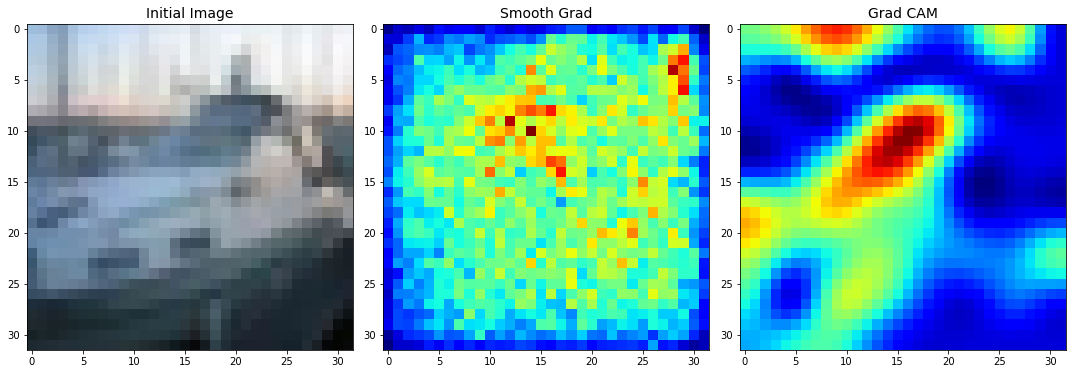

In [23]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].set_title('Initial Image', fontsize=14)
ax[0].imshow(sample, cmap='hot')
ax[1].set_title('Smooth Grad', fontsize=14)
ax[1].imshow(saliency_map[0], cmap='hot')
ax[2].set_title('Grad CAM', fontsize=14)
ax[2].imshow(cam[0], cmap='hot')
plt.tight_layout()
plt.show()

**INTERPRETATION:**

*What happened ?*: our model focused on the wrong parts of the image in order to classify this boat. In terms of structural element of my network, this is maybe because I don't have enough 'dimensions' before the Flattening, which means that too much information is lost when flowing through the different layers. More specifically in terms of regions, we can see from the Grad CAM output that the model is focusing on regions on the sky.

*Change the training set*: We can see from the wrongly classified boat that from the Grad CAM output, the model is looking at the sky. In order to prevent such behaviour from happening, we could have a preprocessing step involving the **Selective Search Algorithm** that would locate the regions where we have an object. Then, we would select this object and use a dark background for instance, or a grey background and then perform classification on top of it. 



<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [45 pts]: Regression with CNN 

[Return to contents](#contents)

<a id="part2intro"></a>

## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="part2questions"></a>

### <div class='exercise'>PART 2: Questions</div> 

[Return to contents](#contents)


<a id="q21"></a>

**[2.1:](#s21) Data preparation**

<a id="q211"></a>

- **[2.1.1:](#s211)** **Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 2.5GB, which can take 10-20 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays? 

<a id="q212"></a>

- **[2.1.2:](#s212)** **Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

<a id="q213"></a>

- **[2.1.3:](#s213)** **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

<a id="q22"></a>

**[2.2:](#s22) Building and training your CNN**

<a id="q221"></a>

- **[2.2.1:](#s221)** **Compiling your model.** Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. Any working setup is acceptable as long as you construct the network yourself and do not use a pre-written implementation.

<a id="q222"></a>

- **[2.2.2:](#s222)** **Training your model.** Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve validation and test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

<a id="q223"></a>

- **[2.2.3:](#s223)** **Saving and loading your weights.** Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?

<a id="q224"></a>

- **[2.2.4:](#s224)** **Evaluating your model.** Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)


<a id="q23"></a>

**[2.3:](#s23) Further Analysis**

<a id="q231"></a>

- **[2.3.1:](#s231)** **Correct an image of your choosing.** Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)

<a id="part2solutions"></a>

## PART 2: Solutions

[Return to contents](#contents)

<a id="s21"></a>
<a id="s211"></a>
<div class='exercise-r'>  

**[2.1:](#q21) Data preparation**

- **[2.1.1:](#q211)** **Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 2.5GB, which can take 10-20 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays?

</div>

In [24]:
# RUN THESE CELLS

# Define our download_celeb function

def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.0.1")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            print(
                "...downloading a {:.2f} GB file."
                "This is going to take a while!".format(length/1e9)
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o)".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o(\n"
            "".format(filename)
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [25]:
%%time
# Download the CelebA dataset from the CS109B S3 bucket
url = "https://cs109b-course-data.s3.amazonaws.com/CelebA/2.0.1.zip"
filename = "2.0.1.zip"
dirname = "data/celeb_a"
dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

download_celeb(url, filename, filepath, dirname, dirpath)

Congratulations...the CelebA dataset already exists locally!
No new downloads are required :o)

CPU times: user 655 µs, sys: 993 µs, total: 1.65 ms
Wall time: 1.5 ms


In [26]:
# This command will use the celeb_a dataset that you downloaded,
# and load it into train and test "tensorflow.Datasets"

train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir = os.path.join(working_dir, "data"),
    download=False,
)

In [27]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [28]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

**INTERPRETATION:**

Aside from pipelining and operatiosn related to data preprocessing (which are already extremely more efficient using a tensorflow dataset), I think the biggest advantage is **computational**. 

We can leverage some operations such as *prefetching* and *caching*. These operations will be useful when our data is too big to be contained in the cache of the GPU (this is directly related to how a multi-core machine is built). The caching operation allow to put the intereseting data in the cache, for faster memory access. Another would be *prefetching*, when the CPU is taking care of rendering resources accessible in a easy way while the GPU is responsible for computations. Some other operations involve the easy parallelization of the pipeline operations, allowing for faster performances.

<a id="s212"></a>
<div class='exercise-r'>  

**[2.1.2:](#q212)** **Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

</div>

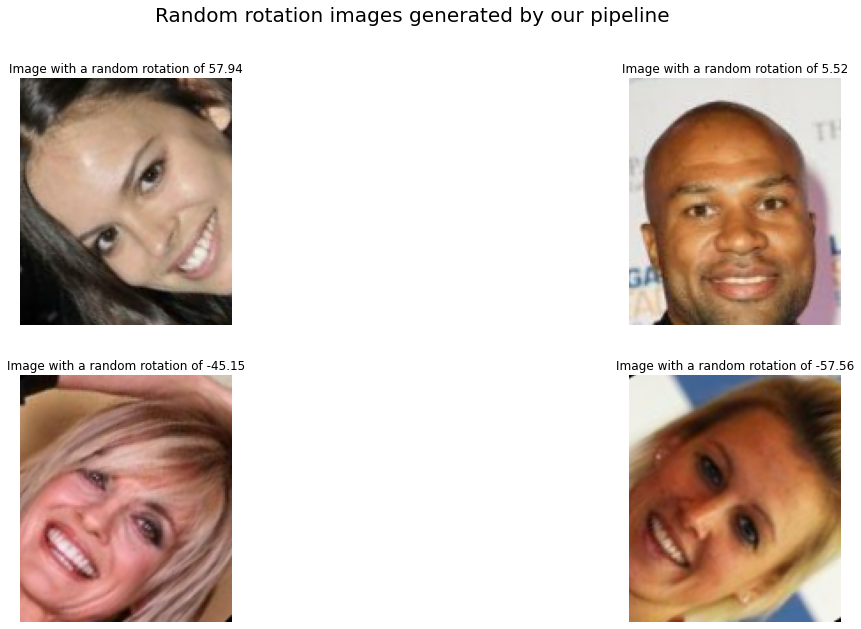

In [29]:
subset = train_rot_ds.take(4)  # this is a generator = implements the __yields__ method
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle('Random rotation images generated by our pipeline', fontsize=20)
for i, (image, label) in enumerate(subset):
    axes.ravel()[i].imshow(image)
    axes.ravel()[i].set_title('Image with a random rotation of '+str(np.round(label, 2)))  
    axes.ravel()[i].axis('off')

<a id="s213"></a>
<div class='exercise-r'>  

**[2.1.3:](#q213)** **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

</div>

**INTERPRETATION:** Let us answer in two parts: first, what is a dropout layer, why use it and what is its effect on  a feed-forward Neural Network, and then what would be its effect on a CNN.

#### 1. Dropout & Feed Forward Neural Networks

The objective of dropout is to prevent to co-adaptation between neurons. In order to do so, it has two effects:
- At training time, some connections are skipped (meaning that the weights are set to zero) with a random probability $p$ (flip a coin)
- At inference time, all the weights are considered by downsampled (multiplied by a factor $1-p$)

Dropout has provable results to reduce overfitting of the Deep FFNN. 

#### 2. Dropout & CNN

In order to understand the effect of dropout on CNN, we need to represent the 2D convolution operator as a linear transformation. 
For the sake of simplicity, let us say that our input is of shape $(5, 5)$ and our kernel size is $(2, 2)$ for our convolution operation. We can represent the convolution operation as the following matrix operation:
$$
\begin{bmatrix}
x_1 & x_2 & x_3\\
x_4 & x_5 & x_6\\
x_7 & x_8 & x_9\\
\end{bmatrix}
*
\begin{bmatrix}
k_1 & k_2\\
k_3 & k_4\\
\end{bmatrix}
=
\begin{bmatrix}
k_1 & k_2 & 0 & k_3 & k_4 & 0 & 0 & 0 & 0\\
0 & k_1 & k_2 & 0 & k_3 & k_4 & 0 & 0 & 0\\
0 & 0 & 0 & k_1 & k_2 & 0 & k_3 & k_4 & 0\\
0 & 0 & 0 & 0 & k_1 & k_2 & 0 & k_3 & k_4 \\
\end{bmatrix}
\begin{bmatrix}
x_1\\ x_2\\  x_3\\  x_4\\  x_5\\  x_6\\  x_7\\  x_8\\  x_9\\
\end{bmatrix}
$$

Therefore, let's say that using dropout, we apply a msk on the first column of our weight matrix (the $K$ matrix). We can see that this will not shutdown the influence of the parameter $k_1$ for the forward pass since it appears also in subsequent operations: this will not prevent our batch from updating the value of $k_1$ during SGD


#### Conclusion: 

Is it a good idea ? We never know with such Deep Neural Networks, but what we know is that dropout does not produce the intended effect.

<a id="s22"></a>
<a id="s221"></a>
<div class='exercise-r'>  

**[2.2:](#q22) Building and training your CNN**

- **[2.2.1:](#q221)** **Compiling your model.** Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. Any working setup is acceptable as long as you construct the network yourself and do not use a pre-written implementation.

</div>

In [30]:
# your code here
# your code here
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(140, 120, 3), batch_size=128))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(5, 5), activation='relu', dilation_rate = 2, kernel_regularizer=tf.keras.regularizers.L1()))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(5, 5), activation='relu', dilation_rate = 2, kernel_regularizer=tf.keras.regularizers.L1()))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1()))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (128, 132, 112, 64)       4864      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (128, 66, 56, 64)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (128, 58, 48, 128)        204928    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (128, 29, 24, 128)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (128, 25, 20, 256)        819456    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (128, 12, 10, 256)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (128, 8, 6, 256)         

In [31]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_squared_error', 'mean_absolute_error'])

<a id="s222"></a>
<div class='exercise-r'>  

**[2.2.2:](#q222)** **Training your model.** Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve validation and test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

</div>

In [32]:
BATCH_SIZE = 128
SEED = 100
history = model.fit(train_rot_ds.batch(batch_size = BATCH_SIZE, drop_remainder=True),
                    validation_data=test_rot_ds.batch(batch_size = BATCH_SIZE, drop_remainder=True),
                    epochs=3,
                   callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/3
1271/1271 [==============================] - 13173s 10s/step - loss: 223.9979 - mean_squared_error: 195.6243 - mean_absolute_error: 9.1938 - val_loss: 48.9103 - val_mean_squared_error: 36.3492 - val_mean_absolute_error: 4.8031
Epoch 2/3
1271/1271 [==============================] - 12791s 10s/step - loss: 59.6561 - mean_squared_error: 48.3385 - mean_absolute_error: 4.9896 - val_loss: 21.5174 - val_mean_squared_error: 12.2569 - val_mean_absolute_error: 2.3199
Epoch 3/3
  61/1271 [>.............................] - ETA: 3:26:22 - loss: 50.1789 - mean_squared_error: 40.9913 - mean_absolute_error: 4.6951

KeyboardInterrupt: 

Even though our validation MSE is > 9, we managed to achieve a rough difference in degrees of < 3 degrees.

<a id="s223"></a>
<div class='exercise-r'>  

**[2.2.3:](#q223)** **Saving and loading your weights.** Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?

</div>

In [ ]:
# your code here
model.save_weights('model/dilated_convolution_weights')
weights = tf.keras.Model.load_weights(model, filepath='model/dilated_convolution_weights')

**INTERPRETATION:** Here, one thing that we should note is that we only save the weights of our model, not the entire model. 

- Why would we want to do that ? Suppose that training time is over, our weights are trained completely and the only remaining interesting thing is inference time. Then the neural network is just a big function with parameters and loading the weights would make sense for getting predictions. 
- What could possibly go wrong ? Let's say that training is not done, and that after loading the weigths, we might want to resume training. Something that **will** go wrong is with the **Optimizer**. There a several strategies of Optimizer: setting a learning rate scheduler of using Adaptive Learning Rate methods (RMSProp or Adam-like). With these methods, we will resume the optimization with the default learning rate, until the optimizer has accumulated some gradients in order to adapt its learning rate, and we never know if we would recover the optimization dynamics from before (same kind of behaviour for the learning rate schedules). This problem is alleviated with saving the entire model because it captures the state of the optimizer.

Another source of randomness that might bring some noise in the training and produce non-identical resuts is the **batching**. It has been shown that random batching of our data includes noise in the SGD procedure (see Frankle et. al 2020, *Linear Mode Connectivity*) and therefore reinitializing the randomness of the batching might create some noise that will be different from the one that would be created should we re-load the weights and interrupt the training. This problem is not solved with the save_model procedure but could be set via fixing the random seed and remembering the last training batch before saving (even though one could argue that architectures should be robust to this sort of random noise).

<a id="s224"></a>
<div class='exercise-r'>  

**[2.2.4:](#q224)** **Evaluating your model.** Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

</div>

![straightened face](data/straightened.png)

In [ ]:
# your code here
subset = test_rot_ds.take(4)  # this is a generator = implements the __yields__ method
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
plt.suptitle('Random rotation images generated by our pipeline and their predictions', fontsize=20)
count = 0
for (image, label) in (subset):
    axes.ravel()[count].imshow(image)
    rotation = model(np.expand_dims(image, axis=0)).numpy()[0][0]
    axes.ravel()[count+1].imshow(rot_resize(image, -rotation))
    axes.ravel()[count+1].set_title('Predicted rotation '+str(np.round(rotation, 2)))  
    axes.ravel()[count+2].imshow(rot_resize(image, -label))
    axes.ravel()[count+2].set_title('Actual rotation '+str(np.round(label, 2)))  
    axes.ravel()[count].axis('off')
    axes.ravel()[count+1].axis('off')
    axes.ravel()[count+2].axis('off')
    count+=3

<a id="s23"></a>
<a id="s231"></a>
<div class='exercise-r'>  

**[2.3:](#q23) Further analysis**

- **[2.3.1:](#q231)** **Correct an image of your choosing.** Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

</div>

![Confused Chris](data/chrisprattcorrection.png)


In [ ]:
# your code here
img = tf.keras.preprocessing.image.load_img('Photo David.jpg', target_size=(140, 120))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
rotation = model(img_tensor).numpy()[0][0]

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
plt.suptitle('Test Set with custom image', fontsize=20)
axes[0].imshow(img)
axes[1].imshow(rot_resize(img_tensor[0], -rotation))
axes[1].set_title('Predicted rotation '+str(np.round(rotation, 1)))
axes[0].axis('off')
axes[1].axis('off')
plt.show(fig)